In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

# Import and Inspect Data

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv', encoding='utf-8')
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')

In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


## Format engagement column

In [9]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement = engagement.sort_values(by=['user_id', 'time_stamp'])

In [10]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


#### Define func to see if user is adopted

In [11]:
def adopted(df):
    login_count = 0
    prev_date = None

    for _, row in df.iterrows():
        if prev_date is None or (row['time_stamp'] - prev_date) <= timedelta(days=7):
            login_count += 1
        else:
            login_count = 1
        prev_date = row['time_stamp']

        if login_count >= 3:
            return True

    return False

In [12]:
result = engagement.groupby('user_id').apply(adopted).reset_index(name='adopted')
result.head(3)

,user_id,adopted
0,1,False
1,2,True
2,3,False


In [13]:
pct_adopted = result[result.adopted == True]['adopted'].count() / result.adopted.count()
pct_adopted

0.2038989006007027

#### Add adoptions result to users df

In [14]:
merged_df = users.merge(result, left_on='object_id', right_on='user_id', how='left')

In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  user_id                     8823 non-null   float64
 11  adopted                     8823 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 1.1+ MB


In [16]:
merged_df.drop(columns='user_id', inplace=True)
merged_df['adopted'].fillna(False, inplace=True)

#### format df for modeling

In [17]:
mod_df = merged_df.drop(columns=['name', 'email', 'object_id', 'last_session_creation_time'])
mod_df['creation_time'] = pd.to_datetime(mod_df['creation_time'])
mod_df.adopted = mod_df.adopted.astype(int)

In [18]:
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   org_id                      12000 non-null  int64         
 5   invited_by_user_id          6417 non-null   float64       
 6   adopted                     12000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 656.4+ KB


In [19]:
mod_df = pd.get_dummies(mod_df, columns=['creation_source'], prefix='cs_')
mod_df['create_yr'] = mod_df['creation_time'].dt.year
mod_df['create_mo'] = mod_df['creation_time'].dt.month
mod_df['create_day'] = mod_df['creation_time'].dt.day
mod_df['create_hr'] = mod_df['creation_time'].dt.hour
mod_df.drop(columns=['creation_time'], inplace=True)
mod_df.invited_by_user_id.fillna(0, inplace=True)

In [20]:
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   opted_in_to_mailing_list    12000 non-null  int64  
 1   enabled_for_marketing_drip  12000 non-null  int64  
 2   org_id                      12000 non-null  int64  
 3   invited_by_user_id          12000 non-null  float64
 4   adopted                     12000 non-null  int64  
 5   cs__GUEST_INVITE            12000 non-null  bool   
 6   cs__ORG_INVITE              12000 non-null  bool   
 7   cs__PERSONAL_PROJECTS       12000 non-null  bool   
 8   cs__SIGNUP                  12000 non-null  bool   
 9   cs__SIGNUP_GOOGLE_AUTH      12000 non-null  bool   
 10  create_yr                   12000 non-null  int32  
 11  create_mo                   12000 non-null  int32  
 12  create_day                  12000 non-null  int32  
 13  create_hr                   120

## create train/test sets

In [21]:
import warnings
warnings.filterwarnings('ignore')

Selected Random Forest Classifier because it is interpretable and does not rely on scale of numeric features.

In [28]:
X = mod_df.drop(columns=['adopted'])
y = mod_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("X: ",X.shape)
print("y: ",y.shape)
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)

X:  (12000, 13)
y:  (12000,)
X_train:  (9600, 13)
y_train:  (9600,)


## Train RFC

#### Hyperparam tuning

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf_model = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')

In [30]:
#Thsi cell Commented out to reduce future ntbk runtime

'''grid_search.fit(X_train, y_train)
grid_search.best_params_''';

^^ OUTPUT:
{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [31]:
best_rfc = RandomForestClassifier(max_depth= 5, n_estimators= 100, 
                                 max_features='auto', min_samples_leaf=1, 
                                 min_samples_split=2)

best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features='auto')

In [32]:
y_pred = best_rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Test set accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Test set accuracy: 84.50%
Precision: 0.00
Recall: 0.00
F1-score: 0.00
ROC AUC: 0.50


Text(0.5, 1.0, 'Feature Importance of Random Forest Regressor')

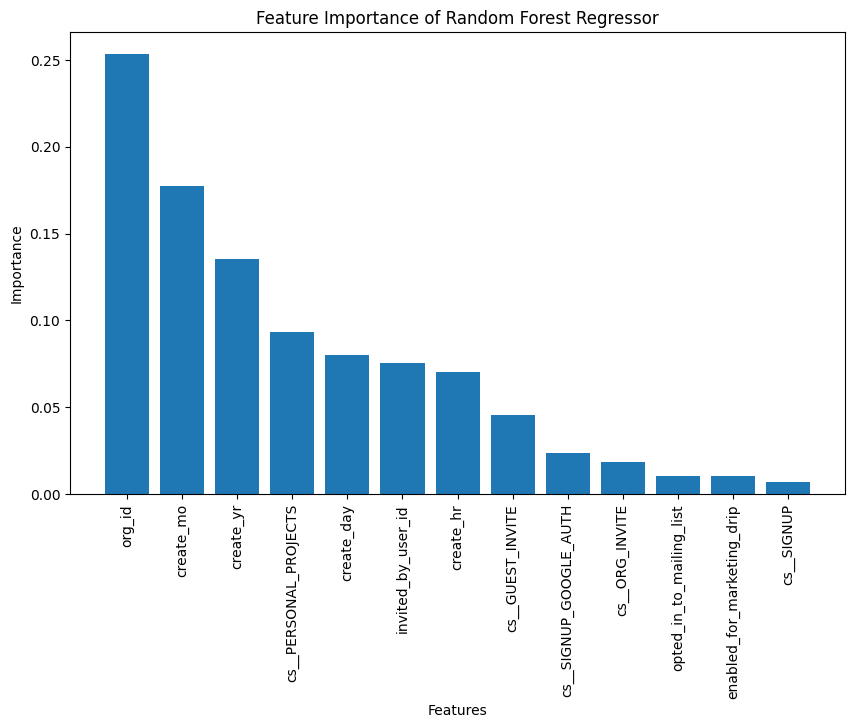

In [27]:
importances = best_rfc.feature_importances_
feature_names = X_train.columns

sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances)
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Regressor')

## Re-train with balanced classes to compare

In [33]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit and transform X_train and y_train
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [34]:
best_rfc = RandomForestClassifier(max_depth= 5, n_estimators= 100, 
                                 max_features='auto', min_samples_leaf=1, 
                                 min_samples_split=2)

best_rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5, max_features='auto')

In [35]:
y_pred = best_rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Test set accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Test set accuracy: 53.12%
Precision: 0.20
Recall: 0.69
F1-score: 0.31
ROC AUC: 0.60


Text(0.5, 1.0, 'Feature Importance of Random Forest Regressor')

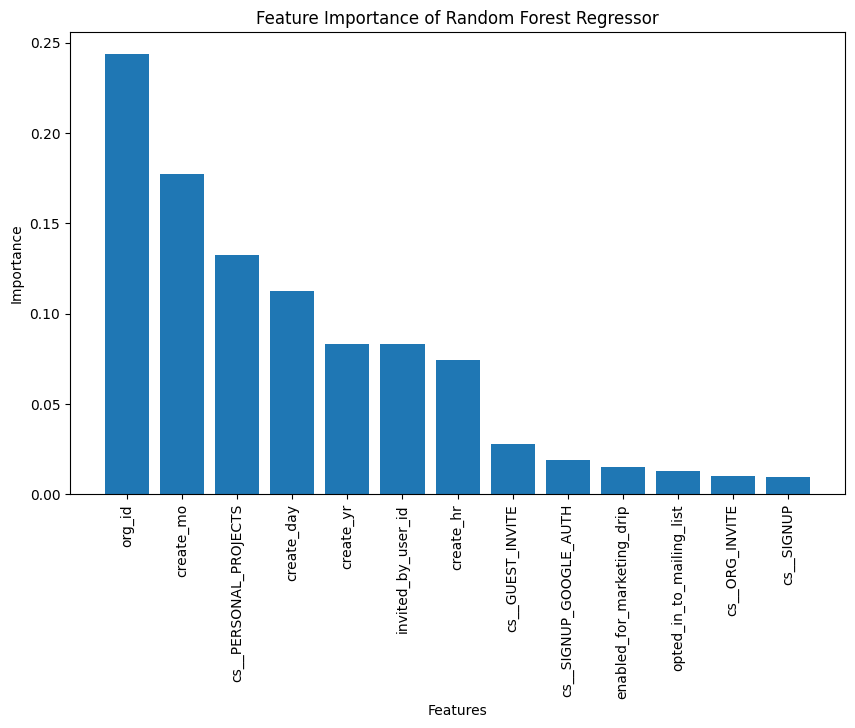

In [36]:
importances = best_rfc.feature_importances_
feature_names = X_train.columns

sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances)
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Regressor')